# PRML 2.3.5 ~ 2.3.6

## 2.3.5 逐次推定
データ点を一度に1つずつ処理しては破棄する。初出はp70?


In [479]:
def unlimited_normal_source(mean, variance):
    while(1):
        yield np.random.normal(mean, np.sqrt(variance))
    
class SequentialMeanEstimator():
    def __init__(self, source):
        self.source = source
        self.mean = 0
        self.count = 1
    
    def update(self):
        new_sample = self.source.next()
        self.mean = self.mean + 1/float(self.count)*(new_sample - self.mean)
        self.count += 1
        return self.mean

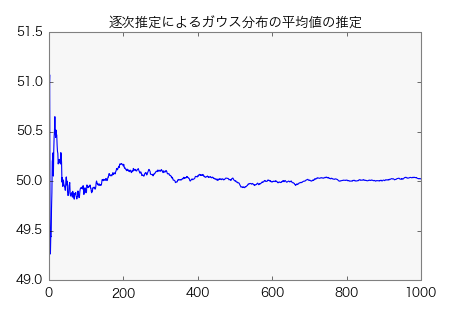

In [495]:
s = SequentialMeanEstimator(unlimited_normal_source(50, 5))
ret = []
for _ in range(1000):
    ret.append(s.update())

plt.plot(ret)
plt.title(u'逐次推定によるガウス分布の平均値の推定')

### Robbins-Monro
逐次アルゴリズムが導出できない物でも、計算できる汎用的な手続き。本文中の例はガウス分布の平均を例としているが、これはRobbins-Monroをやるまでもないので、ガウス分布の分散について逐次で出してみる。平均は既知とする。

$\theta^{(N)} = \theta^{(N-1)} - a_{N-1}\frac{\partial}{\partial V_{N-1}}\{-lnp(x_{N} | \mu, V_{(N-1)})\}$

変形すると

$\theta^{(N)} = \theta^{(N-1)} - a_{N-1}\{0.5/V_{N-1} - (x_{N} - \mu)^2/2V_{N-1}^2\}$

$a_{N-1}$ を $0.999^{N-1}(V_{N-1})$ とおくと、以下のコード

In [530]:
class SequentialVarianceEstimator():
    def __init__(self, source, mean):
        self.source = source
        # 分散の初期値
        self.variance = 3
        self.count = 1
        # 平均は既知とする
        self.mean = mean
        # A(N)の初期値
        self.A = 1
    
    def update(self):
        new_sample = self.source.next()
        self.A = self.A*0.999
        self.variance = self.variance - self.A * (0.5 - ((new_sample - self.mean)**2)/(2 * self.variance))
        self.variance = float(self.variance)
        self.count += 1
        return self.variance

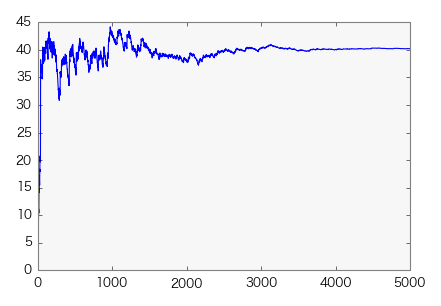

In [531]:
s = SequentialVarianceEstimator(unlimited_normal_source(50, 40), 50)
ret = []
for _ in range(5000):
    ret.append(s.update())

plt.plot(ret)

## 2.3.6 ガウス分布に対するベイズ推論

分散 $\sigma^2$ は既知とし、与えられたN個の観測値集合から平均を推定する


In [483]:
import scipy.stats

In [484]:
mu_0 = 0
sigma2_0 = 1

def samples(mu, sigma2):
    while(1):
         yield np.random.norm(mu, np.sqrt(sigma2))

def calc_mu_N(n, mu_0, mu, sigma2):
    samples = []
    mu_ML = 0
    if n > 0:
        samples = np.random.normal(mu, np.sqrt(sigma2), n)
        mu_ML = np.average(samples)
        
    mu = sigma2/float(n*sigma2 + sigma2) * mu_0 + n*sigma2/float(n*sigma2 + sigma2) * mu_ML
    sigma2N = sigma2*sigma2/(sigma2 + n*sigma2)
    return mu, sigma2N

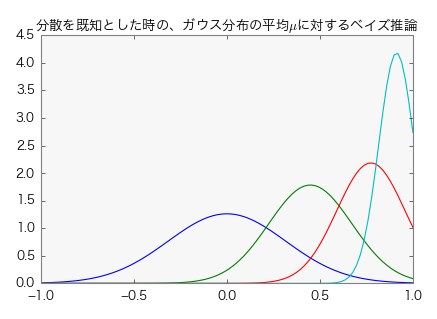

In [485]:
x = np.linspace(-1, 1, 100)
muN, sigma2N = calc_mu_N(0, 0, 0.8, 0.1)
y = scipy.stats.norm.pdf(x, muN, np.sqrt(sigma2N))
plt.plot(x, y)

muN, sigma2N = calc_mu_N(1, 0, 0.8, 0.1)
y = scipy.stats.norm.pdf(x, muN, np.sqrt(sigma2N))
plt.plot(x, y)

muN, sigma2N = calc_mu_N(2, 0, 0.8, 0.1)
y = scipy.stats.norm.pdf(x, muN, np.sqrt(sigma2N))
plt.plot(x, y)

muN, sigma2N = calc_mu_N(10, 0, 0.8, 0.1)
y = scipy.stats.norm.pdf(x, muN, np.sqrt(sigma2N))
plt.plot(x, y)
plt.title(u'分散を既知とした時の、ガウス分布の平均$\mu$に対するベイズ推論')